# 3D CNN

Basic + Batch Norm + Augmentations (invert, rotate, shear, blur, noise) + Dropout (0.025) + l2

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
# import tensorflow as tf

# RANDOM_SEED = 792379571013149
# tf.random.set_seed(RANDOM_SEED)

# print(tf.version.VERSION)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 6
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20210311-194133
Wall time: 32.1 ms


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
    'l2_beta': 0.005,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.025,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': True, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00005,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 50,
    'patience': 50,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 6,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 104, 128, 104, 32) 27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation_1 (Activation)    (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0

In [9]:
load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20210311-100758', 'cp-0106.ckpt')

loading checkpoint from ../../tmp\checkpoints\20210311-100758\cp-0106.ckpt...


In [10]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [11]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20210311-194133
checkpoint dir: ../../tmp\checkpoints\20210311-194133
log dir: ../../tmp\logs\20210311-194133
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.5332 - recall: 0.9577 - precision: 0.9577 - auc: 0.9922 - categorical_accuracy: 0.9577
Epoch 00001: val_auc improved from -inf to 0.82070, saving model to ../../tmp\checkpoints\20210311-194133\cp-0001.ckpt
67/67 [==============================] - 65s 972ms/step - loss: 1.5332 - recall: 0.9577 - precision: 0.9577 - auc: 0.9922 - categorical_accuracy: 0.9577 - val_loss: 1.8407 - val_recall: 0.7700 - val_precision: 0.7700 - val_auc: 0.8207 - val_categorical_accuracy: 0.7700
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.5610 - recall: 0.9353 - precision: 0.9353 - auc: 0.9858 - categorical_accuracy: 0.9353
Epoch 00002: val_auc imp

Epoch 17/50
67/67 [==============================] - ETA: 0s - loss: 1.5386 - recall: 0.9552 - precision: 0.9552 - auc: 0.9917 - categorical_accuracy: 0.9552
Epoch 00017: val_auc did not improve from 0.82120
67/67 [==============================] - 63s 941ms/step - loss: 1.5386 - recall: 0.9552 - precision: 0.9552 - auc: 0.9917 - categorical_accuracy: 0.9552 - val_loss: 1.8412 - val_recall: 0.7700 - val_precision: 0.7700 - val_auc: 0.8194 - val_categorical_accuracy: 0.7700
Epoch 18/50
67/67 [==============================] - ETA: 0s - loss: 1.5490 - recall: 0.9502 - precision: 0.9502 - auc: 0.9900 - categorical_accuracy: 0.9502
Epoch 00018: val_auc did not improve from 0.82120
67/67 [==============================] - 63s 942ms/step - loss: 1.5490 - recall: 0.9502 - precision: 0.9502 - auc: 0.9900 - categorical_accuracy: 0.9502 - val_loss: 1.8411 - val_recall: 0.7700 - val_precision: 0.7700 - val_auc: 0.8191 - val_categorical_accuracy: 0.7700
Epoch 19/50
67/67 [=========================

## Evaluation

Wall time: 78.2 ms


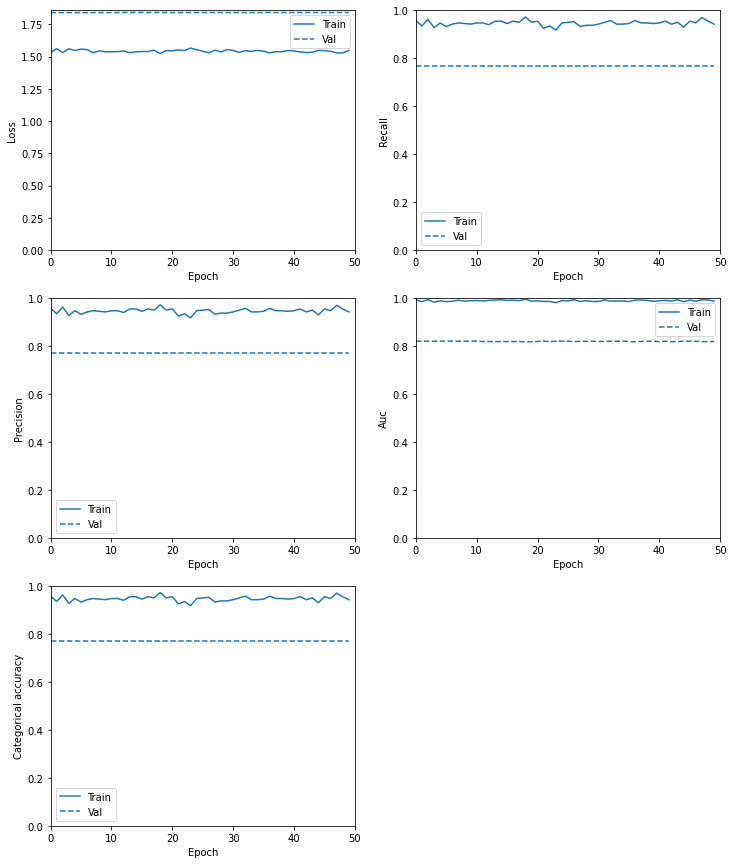

In [12]:
%%time

plot_training_history(history)

In [13]:
%%time

show_simple_metrics(model, test_seq)

loss: 1.8397471904754639
recall: 0.7699999809265137
precision: 0.7699999809265137
auc: 0.8197999596595764
categorical_accuracy: 0.7699999809265137

Wall time: 23.2 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8305084745762712
recall: 0.7903225806451613
f1-score: 0.8099173553719008
support: 62


CN
precision: 0.6829268292682927
recall: 0.7368421052631579
f1-score: 0.7088607594936709
support: 38


micro avg
precision: 0.77
recall: 0.77
f1-score: 0.7699999999999999
support: 100


macro avg
precision: 0.756717651922282
recall: 0.7635823429541595
f1-score: 0.7593890574327858
support: 100


weighted avg
precision: 0.7744274493592394
recall: 0.77
f1-score: 0.7715158489381735
support: 100


samples avg
precision: 0.77
recall: 0.77
f1-score: 0.77
support: 100


F1
micro: 0.7699999999999999
macro: 0.7593890574327858


accuracy_score: 0.77
sensitivity_score: 0.7903225806451613
specificity_score: 0.7368421052631579


Wall time: 25.6 s


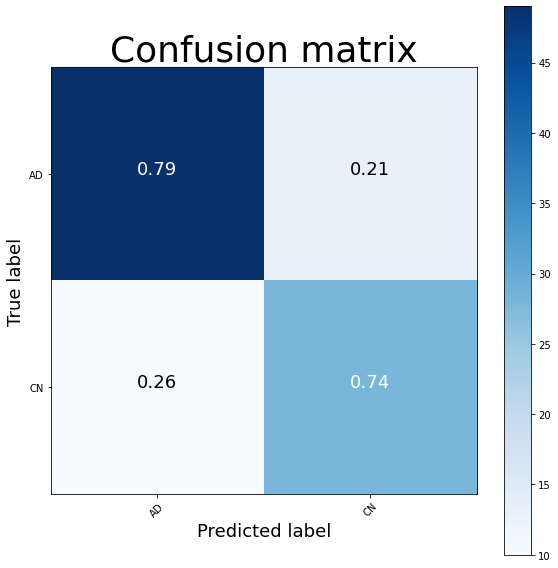

In [14]:
%%time

show_metrics(model, test_seq, class_names)